In [1]:
# libraries to use
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import gc
from itertools import product
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings(action='ignore')

data_path = '../../../Data/future_sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [2]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        percent_mem_change = 100 * (start_mem - end_mem) / start_mem
        print(f"The percent memory change is: {percent_mem_change}")
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

The percent memory change is: 54.16661592897757
The percent memory change is: 38.46153846153846
The percent memory change is: 54.153232170638766
The percent memory change is: 39.83739837398374
The percent memory change is: 70.83151459696413


<Axes: >

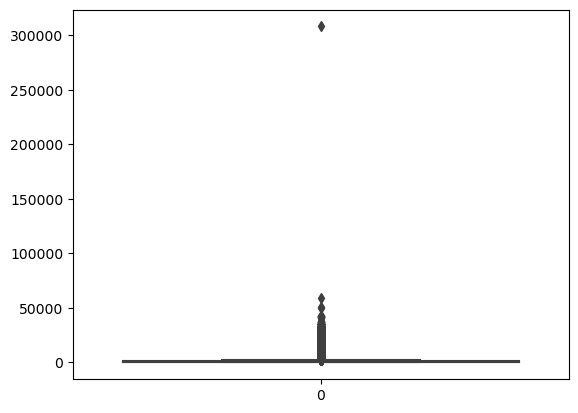

In [3]:
sns.boxplot(sales_train['item_price'])

<Axes: >

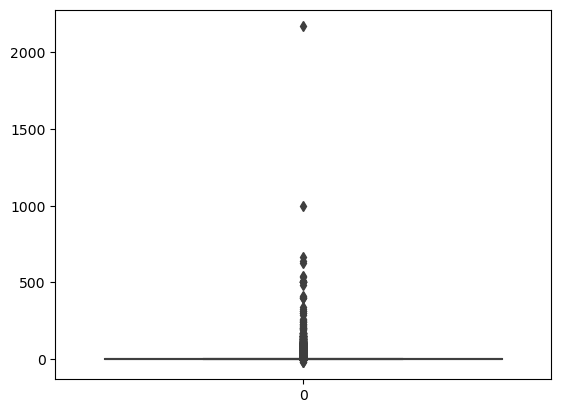

In [4]:
sns.boxplot(sales_train['item_cnt_day'])

In [5]:
# This removes outliers in the data. 
sales_train = sales_train.loc[(sales_train['item_price'] > 0) & (sales_train['item_price'] < 100000)]
sales_train = sales_train.loc[(sales_train['item_cnt_day'] > 0) & (sales_train['item_cnt_day'] < 900)]

In [6]:
shops["shop_first_name"] = shops["shop_name"].apply(lambda x: x.split()[0])

In [7]:
shops["shop_first_name"].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [8]:
shops.loc[shops["shop_first_name"] =='!Якутск', "shop_first_name"] = 'Якутск'

In [9]:
# Changes string variables with numeric type. 
label_encoder = LabelEncoder()
shops["shop_first_name"] = label_encoder.fit_transform(shops["shop_first_name"])

In [10]:
shops = shops.drop("shop_name", axis=1)

In [11]:
shops.head()

,shop_id,shop_first_name
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [12]:
items = items.drop(["item_name"], axis=1)

In [13]:
items["item_date_block"] = sales_train.groupby("item_id").agg({"date_block_num": 'min'})["date_block_num"]
items.head()

,item_id,item_category_id,item_date_block
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [14]:
items.loc[items["item_date_block"].isna()]

,item_id,item_category_id,item_date_block
83,83,40,NaN
140,140,45,NaN
168,168,44,NaN
173,173,45,NaN
204,204,44,NaN
...,...,...,...
21974,21974,61,NaN
21975,21975,61,NaN
22022,22022,40,NaN
22035,22035,40,NaN


In [15]:
items["item_date_block"] = items["item_date_block"].fillna(34)

### Item Category exploration

In [17]:
# Extracts first name of the items.
item_categories["first_item_category_name"] = item_categories["item_category_name"].apply(lambda x: x.split()[0])  

In [18]:
item_categories["first_item_category_name"].value_counts()

first_item_category_name
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [19]:
def make_etc(x):
    if len(item_categories[item_categories["first_item_category_name"]==x]) >= 5:
        return x
    else:
        return 'etc'

item_categories["first_item_category_name"] = item_categories["first_item_category_name"].apply(make_etc)

In [20]:
item_categories.head()

,item_category_name,item_category_id,first_item_category_name
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [21]:
label_encoder = LabelEncoder()
item_categories["first_item_category_name"] = label_encoder.fit_transform(item_categories["first_item_category_name"])
item_categories = item_categories.drop("item_category_name", axis=1)

In [22]:
train = []
for i in sales_train["date_block_num"].unique():
    all_shop = sales_train.loc[sales_train["date_block_num"]==i, "shop_id"].unique()
    all_item = sales_train.loc[sales_train["date_block_num"]==i, "item_id"].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ["date_block_num", "shop_id", "item_id"]
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [23]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={"item_cnt_day": "item_cnt_day_sum",
                              "item_price": "item_price_mean"})

train = train.merge(group, on=idx_features, how='left')

In [24]:
train

,date_block_num,shop_id,item_id,item_cnt_day_sum,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN
...,...,...,...,...,...
10884503,33,21,7635,NaN,NaN
10884504,33,21,7638,NaN,NaN
10884505,33,21,7640,NaN,NaN
10884506,33,21,7632,NaN,NaN


In [25]:
del group
gc.collect();

In [26]:
group = sales_train.groupby(idx_features).agg({"item_cnt_day": 'count'})
group = group.reset_index()
group = group.rename(columns={"item_cnt_day": "item_cnt_day_count"})

train = train.merge(group, on=idx_features, how='left')

del group, sales_train
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_day_sum,item_price_mean,item_cnt_day_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [27]:
train.tail()

,date_block_num,shop_id,item_id,item_cnt_day_sum,item_price_mean,item_cnt_day_count
10884503,33,21,7635,NaN,NaN,NaN
10884504,33,21,7638,NaN,NaN,NaN
10884505,33,21,7640,NaN,NaN,NaN
10884506,33,21,7632,NaN,NaN,NaN
10884507,33,21,7440,NaN,NaN,NaN


In [28]:
test["date_block_num"] = 34
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_day_sum,item_price_mean,item_cnt_day_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [29]:
all_data = all_data.merge(shops, on="shop_id", how='left')
all_data = all_data.merge(items, on="item_id", how='left')
all_data = all_data.merge(item_categories, on="item_category_id", how='left')

all_data = downcast(all_data)

The percent memory change is: 64.15092900066568


In [30]:
del shops, items, item_categories
gc.collect();

In [31]:
all_data.tail()

,date_block_num,shop_id,item_id,item_cnt_day_sum,item_price_mean,item_cnt_day_count,shop_first_name,item_category_id,item_date_block,first_item_category_name
11098703,34,45,18454,0,0.0,0,20,55,23,7
11098704,34,45,16188,0,0.0,0,20,64,32,8
11098705,34,45,15757,0,0.0,0,20,55,0,7
11098706,34,45,19648,0,0.0,0,20,40,23,5
11098707,34,45,969,0,0.0,0,20,37,17,5


In [32]:
def add_mean_features(df, mean_features, idx_features):
    
    assert (idx_features[0] == "date_block_num") and \
           len(idx_features) in [2, 3]
    
    if len(idx_features) == 2:
        feature_name = idx_features[1] + "idx_features_3"
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + "idx_features_4"
    
    group = df.groupby(idx_features).agg({"item_cnt_day_sum": 'mean'})
    group = group.reset_index()
    group = group.rename(columns={"item_cnt_day_sum": feature_name})
    
    df = df.merge(group, on=idx_features, how='left')
    df = downcast(df, verbose=False)
    mean_features.append(feature_name)
    
    del group
    gc.collect()
    
    return df, mean_features

In [33]:
item_mean_features = []

all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=["date_block_num", "item_id"])

all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=["date_block_num", "item_id", "shop_first_name"])

In [66]:
item_mean_features

['item_ididx_features_3', 'item_id shop_first_nameidx_features_4']

In [68]:
shop_mean_features = []

all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=["date_block_num", "shop_id", "item_category_id"])

In [70]:
shop_mean_features

['shop_id item_category_ididx_features_4']

In [72]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    df_temp = df[idx_features + [lag_feature]].copy() 

    for i in range(1, nlags+1):
        lag_feature_name = lag_feature +"lag" + str(i)
        df_temp.columns = idx_features + [lag_feature_name]
        df_temp["date_block_num"] += 1
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    df = downcast(df, False)
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [74]:
lag_features_to_clip = []
idx_features = ["date_block_num", "shop_id", "item_id"]

all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature="item_cnt_day_sum", 
                                                  nlags=3,
                                                  clip=True)

In [75]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_day_sum,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_cnt_day_count,1.000000,0.000000,0.000000,0.000000,0.000000
shop_first_name,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
item_date_block,0.000000,0.000000,0.000000,0.000000,0.000000
first_item_category_name,5.000000,7.000000,7.000000,7.000000,7.000000


In [76]:
lag_features_to_clip

['item_cnt_day_sumlag1', 'item_cnt_day_sumlag2', 'item_cnt_day_sumlag3']

In [80]:
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature="item_cnt_day_count", 
                                                  nlags=3)

all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature="item_price_mean", 
                                                  nlags=3)

In [81]:
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
all_data = all_data.drop(item_mean_features, axis=1)

In [84]:
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=["date_block_num", "shop_id", "item_category_id"], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
all_data = all_data.drop(shop_mean_features, axis=1)

In [86]:
all_data = all_data.drop(all_data[all_data["date_block_num"] < 3].index)

In [88]:
all_data["clipped_lag_features"] = all_data[["item_cnt_day_sumlag1",
                                          "item_cnt_day_sumlag2", 
                                          "item_cnt_day_sumlag3"]].mean(axis=1)

In [90]:
all_data[lag_features_to_clip + ["item_cnt_day_sum", "clipped_lag_features"]] = all_data[lag_features_to_clip + ["item_cnt_day_sum", "clipped_lag_features"]].clip(0, 20)

In [92]:
all_data["lag_1_2_combined"] = all_data["item_cnt_day_sumlag1"]/all_data["item_cnt_day_sumlag2"]
all_data["lag_1_2_combined"] = all_data["lag_1_2_combined"].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data["lag_2_3_combined"] = all_data["item_cnt_day_sumlag2"]/all_data["item_cnt_day_sumlag3"]
all_data["lag_2_3_combined"] = all_data["lag_2_3_combined"].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [96]:
all_data["item_date_block_equal"] = all_data["item_date_block"] == all_data["date_block_num"]

In [98]:
all_data["item_date_block_minus"] = all_data["date_block_num"] - all_data["item_date_block"]

In [100]:
all_data["month"] = all_data["date_block_num"] % 12

In [102]:
all_data = all_data.drop(["item_date_block", "item_price_mean", "item_cnt_day_count"], axis=1)

In [103]:
all_data = downcast(all_data, False)

In [105]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9976322 entries, 1122386 to 11098707
Data columns (total 32 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   date_block_num                              int8   
 1   shop_id                                     int8   
 2   item_id                                     int16  
 3   item_cnt_day_sum                            int8   
 4   shop_first_name                             int8   
 5   item_category_id                            int8   
 6   first_item_category_name                    int8   
 7   item_cnt_day_sumlag1                        int8   
 8   item_cnt_day_sumlag2                        int8   
 9   item_cnt_day_sumlag3                        int8   
 10  item_cnt_day_countlag1                      int8   
 11  item_cnt_day_countlag2                      int8   
 12  item_cnt_day_countlag3                      int8   
 13  item_price_meanlag1 

In [108]:
X_train = all_data[all_data["date_block_num"] < 33]
X_train = X_train.drop(["item_cnt_day_sum"], axis=1)

X_valid = all_data[all_data["date_block_num"] == 33]
X_valid = X_valid.drop(["item_cnt_day_sum"], axis=1)

X_test = all_data[all_data["date_block_num"] == 34]
X_test = X_test.drop(["item_cnt_day_sum"], axis=1)

y_train = all_data[all_data["date_block_num"] < 33]["item_cnt_day_sum"]

y_valid = all_data[all_data["date_block_num"] == 33]["item_cnt_day_sum"]


del all_data
gc.collect();

In [110]:
import lightgbm as lgb

params = {'metric': 'rmse', 
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

cat_features = ["shop_id", "shop_first_name", "item_category_id", "first_item_category_name", "month"]

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100) 

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
preds = lgb_model.predict(X_test).clip(0, 20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [ ]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();